In [22]:
from imgaug import augmenters as iaa
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from os import path

In [107]:
if not os.path.isdir('Val_Pokemon_data/'):
    os.mkdir('Val_Pokemon_data/')

classes = ['Bulbasaur', 'Pikachu', 'Meowth']

for c in classes:
    p = os.path.join('Val_Pokemon_data', c)
    if not os.path.isdir(p):        
        os.mkdir(p)

In [116]:
folder = 'Pokemon_data/'
split = 0.9

for f in os.listdir(folder):
    path = os.path.join(folder, f)
    imgs = os.listdir(path)
    
    split_size = int(len(imgs) * split)
    file_to_move = imgs[split_size:]
    for img_f in file_to_move:
        src = os.path.join(path, img_f) 
        dest = os.path.join('Val_Pokemon_data/' + f, img_f) 
       
        # shutil.move(src, dest)
        

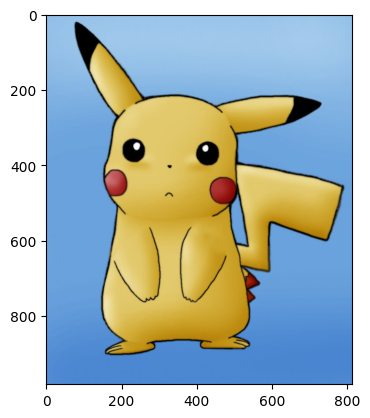

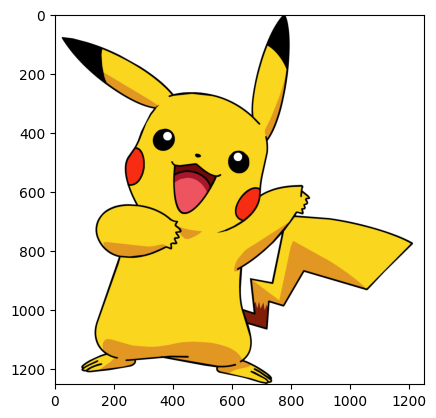

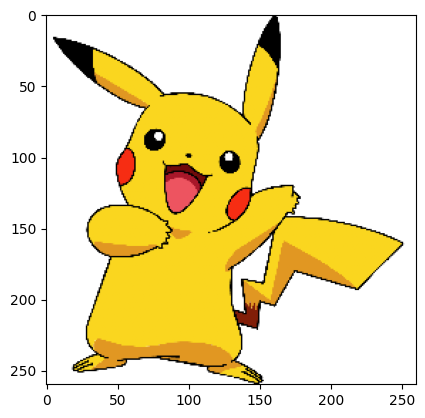

In [117]:
img1 = image.load_img('296.jpg')
img1 = image.img_to_array(img1)/255.0
img2 = image.load_img('297.jpg')
img2 = image.img_to_array(img2)/255.0
imgnew = image.load_img('297.jpg', target_size=(260, 260))
imgnew = image.img_to_array(imgnew)/255.0

plt.imshow(img1) 
plt.show()
plt.imshow(img2) 
plt.show()
plt.imshow(imgnew) 
plt.show()

In [135]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.5), # vertically flip 50% of the images
    # # iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
    # iaa.Sometimes(
    #     0.5,
    #     iaa.GaussianBlur(sigma=(0, 0.5))
    # # ),
     iaa.Sometimes(
         0.3,
         iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-20, 20),
            shear=(-8, 8),
            order=[0, 1],
    )),
])

In [119]:
batch = img2.reshape((1, *img2.shape))
batch.shape

(1, 1254, 1254, 3)

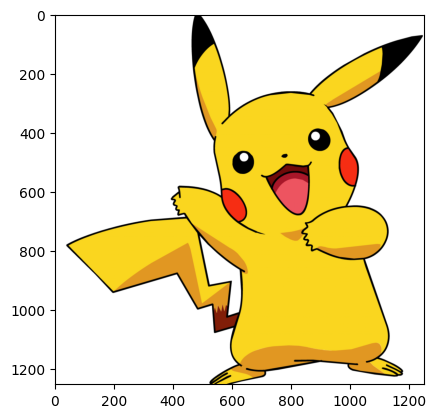

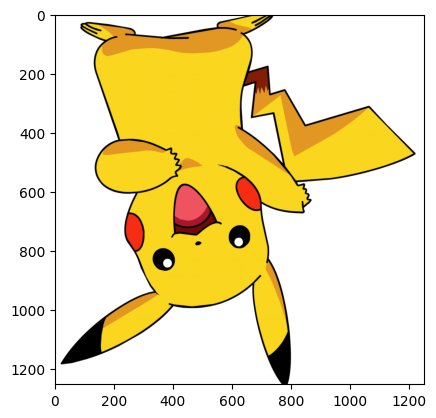

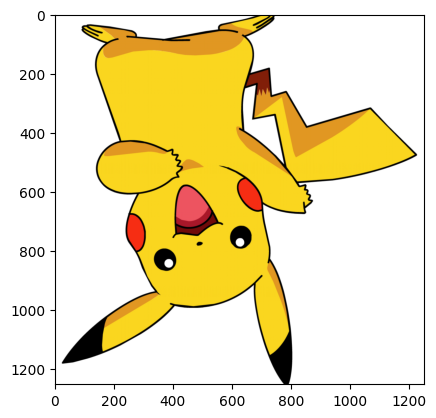

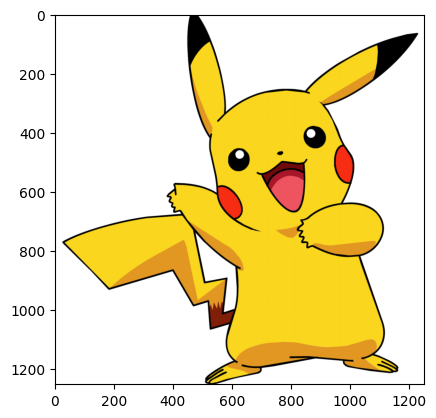

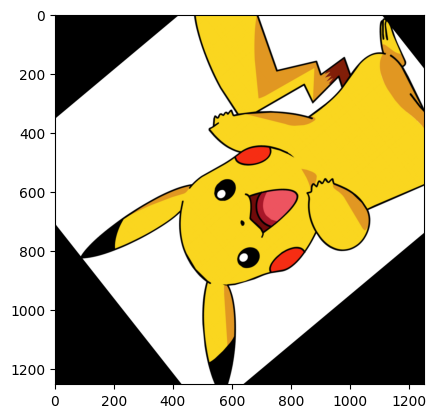

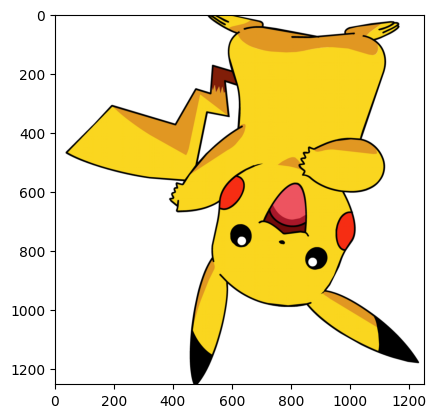

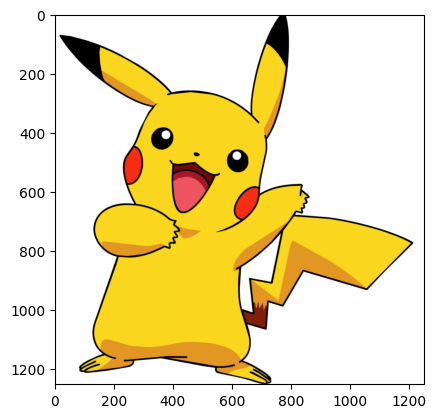

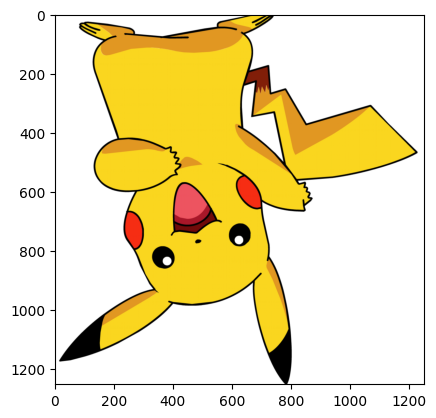

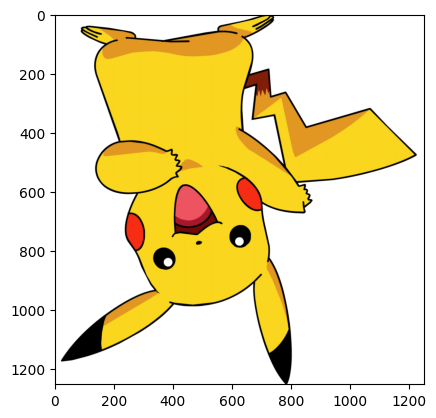

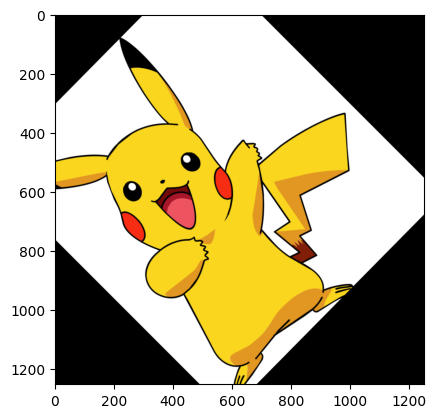

In [121]:
for i in range(10):
    output = seq(images=batch)
    plt.imshow(output[0])
    plt.show()

In [122]:
from keras.preprocessing import image
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [179]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                rotation_range=20,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest'
                )
train_generator = train_datagen.flow_from_directory(
    'Pokemon_data/',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_datagen.flow_from_directory(
    'Val_Pokemon_data/',
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
)

Found 590 images belonging to 3 classes.
Found 67 images belonging to 3 classes.


In [180]:
name2idx = train_generator.class_indices
idx2name = dict([(v, k) for (k, v) in name2idx.items()])
idx2name

{0: 'Bulbasaur', 1: 'Meowth', 2: 'Pikachu'}

(32, 100, 100, 3) (32, 3)


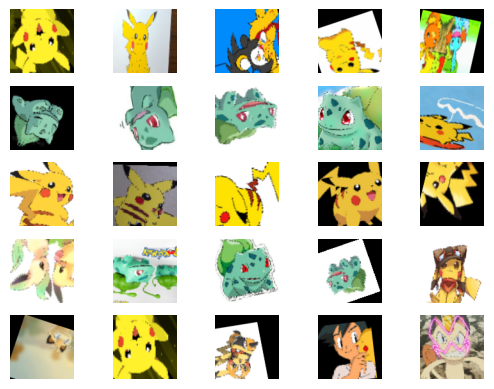

(32, 100, 100, 3) (32, 3)


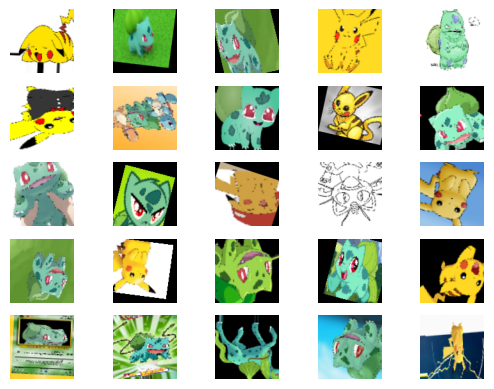

(32, 100, 100, 3) (32, 3)


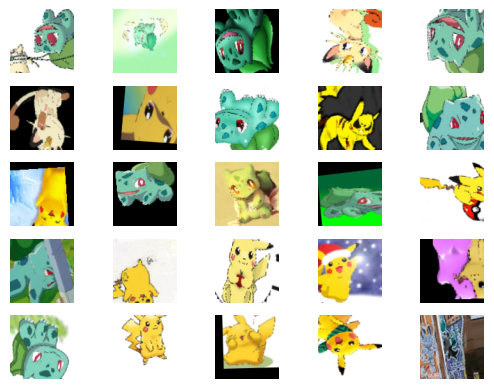

(32, 100, 100, 3) (32, 3)


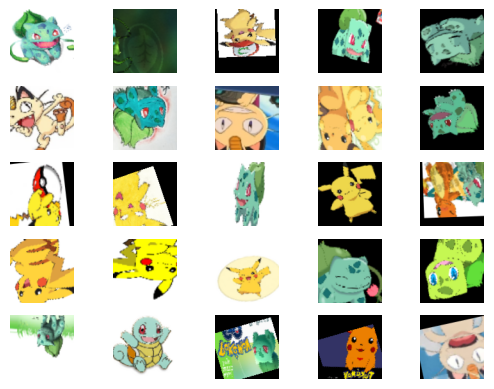

In [187]:
for cnt, (x, y) in enumerate(train_generator):
    x = seq(images=x)
    print(x.shape, y.shape)
    for i in range(25):
        plt.subplot(5,5,i + 1)
        plt.axis("off")
        plt.imshow(x[i])
    plt.show()
    if cnt == 3:
        break

In [182]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras import models

In [183]:
model = models.Sequential()
model.add(Convolution2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten()) # use Global Average Pooling instead which reduces the matrix size more over
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 25, 25, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 12, 12, 64)       

In [184]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [185]:
hist = model.fit_generator(train_generator, epochs=50, steps_per_epoch=10, validation_data=val_generator, validation_steps=3)

Epoch 1/50
10/10 [==============================] - 8s 592ms/step - loss: 0.9914 - accuracy: 0.4437 - val_loss: 0.9588 - val_accuracy: 0.4478
Epoch 2/50
10/10 [==============================] - 6s 580ms/step - loss: 0.9434 - accuracy: 0.6219 - val_loss: 0.8728 - val_accuracy: 0.8060
Epoch 3/50
10/10 [==============================] - 5s 516ms/step - loss: 0.8629 - accuracy: 0.7318 - val_loss: 0.8061 - val_accuracy: 0.6269
Epoch 4/50
10/10 [==============================] - 5s 526ms/step - loss: 0.6903 - accuracy: 0.7550 - val_loss: 0.5983 - val_accuracy: 0.7463
Epoch 5/50
10/10 [==============================] - 6s 576ms/step - loss: 0.5371 - accuracy: 0.7969 - val_loss: 0.5394 - val_accuracy: 0.7612
Epoch 6/50
10/10 [==============================] - 5s 497ms/step - loss: 0.4657 - accuracy: 0.8179 - val_loss: 0.5107 - val_accuracy: 0.7761
Epoch 7/50
10/10 [==============================] - 6s 667ms/step - loss: 0.4633 - accuracy: 0.8031 - val_loss: 0.4454 - val_accuracy: 0.8358
Epoch 

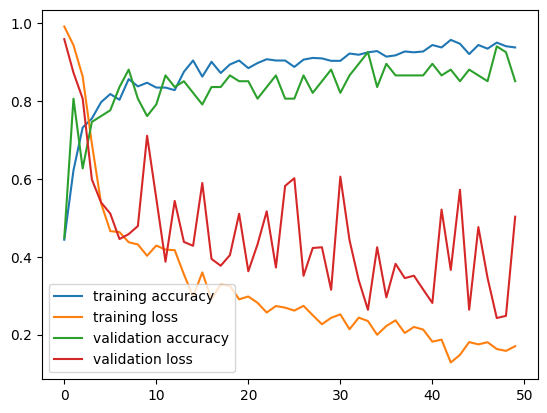

In [186]:
h = hist.history
acc = h['accuracy']
val_acc = h['val_accuracy']
loss = h['loss']
val_loss = h['val_loss']
plt.plot(acc, label='training accuracy')
plt.plot(loss, label='training loss')
plt.plot(val_acc, label='validation accuracy')
plt.plot(val_loss, label='validation loss')
plt.legend()

In [218]:
batch = []
labels = []
for img_f in os.listdir('Test_Pokemon_data/'):
    img = image.load_img('Test_Pokemon_data/' + img_f, target_size=(100, 100, 3))
    labels.append(img_f)
    img = image.img_to_array(img)/255.0
    batch.append(img)
batch = np.asarray(batch)
pred = model.predict(batch)
print(labels)
print(pred)
for i in range(pred.shape[0]):
    print(idx2name[np.argmax(pred[i])])    

1/1 [==============================] - 0s 53ms/step
['296.jpg', '297.jpg', '298.jpg', '299.jpg', '300.jpg', '301.jpg', '302.jpg', '303.jpg']
[[0.00520988 0.02279447 0.97199565]
 [0.0157105  0.0102218  0.9740676 ]
 [0.02663974 0.70456046 0.26879984]
 [0.07347398 0.9245392  0.0019868 ]
 [0.6745051  0.300296   0.02519886]
 [0.07496865 0.02468451 0.9003468 ]
 [0.14252797 0.8536282  0.00384376]
 [0.08658159 0.9105433  0.00287508]]
Pikachu
Pikachu
Meowth
Meowth
Bulbasaur
Pikachu
Meowth
Meowth


In [195]:
train_generator.class_indices

{'Bulbasaur': 0, 'Meowth': 1, 'Pikachu': 2}